In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# מוסיף את תיקיית השורש של הפרויקט לנתיב החיפוש של פייתון
sys.path.append(os.path.abspath(os.path.join('..')))

from sigmoids_model import SigmoidsModel
from simulation.generator import SyntheticDataGenerator
import gzip

def calculate_mse(estimated_counts, true_distribution, bins):
    """
    מחשב את השגיאה הריבועית הממוצעת בין ההתפלגות המשוערת לאמת.
    """
    # נרמול שתי ההתפלגויות כדי שיהיו באותה קנה מידה (Density)
    est_density = estimated_counts / np.sum(estimated_counts)
    true_density = true_distribution / np.sum(true_distribution)
    return np.mean((est_density - true_density)**2)

def split_tagalign(input_path, train_path, test_path, train_ratio=0.5):
    """ מפצל קובץ קיים לשניים ללא טעינה לזיכרון """
    with gzip.open(input_path, 'rt') as f_in, \
         gzip.open(train_path, 'wt') as f_train, \
         gzip.open(test_path, 'wt') as f_test:
        for line in f_in:
            if np.random.random() < train_ratio:
                f_train.write(line)
            else:
                f_test.write(line)

In [3]:
def gmm_length_dist(n):
    mus, sigmas, weights = [175.2, 321.5, 464.1], [18.4, 50.2, 21.2], [0.55, 0.40, 0.05]
    components = np.random.choice(len(weights), size=n, p=weights)
    lengths = np.zeros(n)
    for i in range(len(weights)):
        mask = (components == i)
        lengths[mask] = np.random.normal(mus[i], sigmas[i], np.sum(mask))
    return np.clip(lengths, 100, 600).astype(int)

def true_lambda_func(l):
    A, C, x1, k1, x2, k2 = 0.29, 0.03, 172.8, 22.1, 534.3, 71.2
    sig = lambda t: 1 / (1 + np.exp(-t))
    return C + A * sig((l - x1) / k1) * sig((x2 - l) / k2)

In [5]:
depths_to_test = [0.05, 0.1, 0.2, 0.5, 1.0]
results = []

for c in depths_to_test:
    print(f"Testing depth c = {c}...")
    
    # 1. ייצור דאטא סינתטי מלא
    gen = SyntheticDataGenerator(N=200000, depth_c=c, 
                                 length_dist_func=gmm_length_dist, 
                                 lambda_func=true_lambda_func)
    full_file = f"temp_c_{c}.tagAlign.gz"
    gen.simulate_sequencing(full_file)
    
    # 2. פיצול ל-Train/Test (הגרלה של 50/50)
    train_file, test_file = f"train_c_{c}.gz", f"test_c_{c}.gz"
    split_tagalign(full_file, train_file, test_file)
    
    # 3. אימון המודל על ה-Train
    # שימי לב: ה-Fitting קורה אוטומטית בתוך ה-__init__ במחלקה שלך
    model_train = SigmoidsModel(train_file)
    
    # 4. הכנת נתוני ה-Test (ללא Fitting פנימי של ה-Test)
    model_test = SigmoidsModel(test_file)
    
    # 5. תיקון ה-Test בעזרת הלמדאות של ה-Train
    # אנחנו לוקחים את ה-M של ה-Test ומחלקים ב-lambda שחוזה המודל של ה-Train
    corrected_test_N = []
    for m, b_start in zip(model_test.M_per_bin, model_test.raw_bin_starts):
        lam_from_train = model_train.predict_lambda(b_start) # שימוש במודל הלמדא של ה-Train
        corrected_test_N.append(m / lam_from_train if lam_from_train > 0 else 0)
    
    corrected_test_N = np.array(corrected_test_N)
    
    # 6. חישוב MSE מול ההתפלגות המקורית (Ground Truth)
    # נשתמש באורכים האמיתיים שנוצרו ב-Generator כרפרנס
    bins = np.array(model_test.raw_bin_starts)
    true_counts, _ = np.histogram(gen.fragments, bins=np.append(bins, bins[-1] + model_test.bin_size))
    
    mse = calculate_mse(corrected_test_N, true_counts, model_test.bin_size)
    results.append((c, mse))
    print(f"Depth {c} completed. MSE: {mse:.2e}")

Testing depth c = 0.05...
Generating library with 200000 unique fragments...
Simulating sequencing with target depth c=0.05...
chr1	21000	21168
chr1	27000	27325
chr1	70000	70289
chr1	90000	90311
chr1	184000	184198
chr1	190000	190143
chr1	210000	210174
chr1	227000	227180
chr1	260000	260167
chr1	281000	281314
------------------------------
Measured Depth (c_measured): 0.0495
Processing file: train_c_0.05.gz...
Estimating lambdas...
Fitting model...
Done!
Processing file: test_c_0.05.gz...
Estimating lambdas...
Fitting model...
Done!
Depth 0.05 completed. MSE: 1.88e-04
Testing depth c = 0.1...
Generating library with 200000 unique fragments...
Simulating sequencing with target depth c=0.1...
chr1	10000	10176
chr1	19000	19166
chr1	32000	32144
chr1	35000	35174
chr1	42000	42190
chr1	79000	79208
chr1	87000	87130
chr1	113000	113194
chr1	122000	122344
chr1	129000	129191
------------------------------
Measured Depth (c_measured): 0.1001
Processing file: train_c_0.1.gz...
Estimating lambdas...
Fi

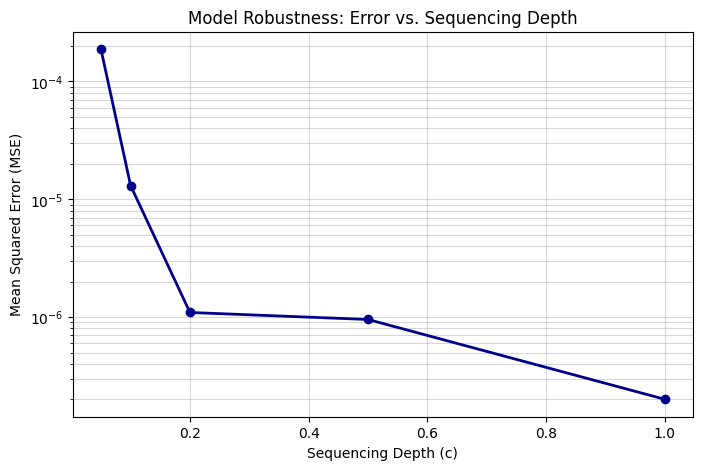

In [6]:
depths, mses = zip(*results)

plt.figure(figsize=(8, 5))
plt.plot(depths, mses, 'o-', linewidth=2, color='darkblue')
plt.yscale('log') # שגיאות לרוב נראות טוב יותר בסקלה לוגית
plt.xlabel('Sequencing Depth (c)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Robustness: Error vs. Sequencing Depth')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sigmoids_model import SigmoidsModel

def get_gmm_density(x, params):
    """מחשבת את ה-PDF של ה-GMM האמיתי עבור מערך איקסים"""
    density = np.zeros_like(x, dtype=float)
    for mu, sigma, w in params:
        term = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
        density += w * term
    return density

def calculate_mse(d1, d2):
    """MSE פשוט בין שתי התפלגויות נורמליות"""
    return np.mean((d1 - d2)**2)

# פרמטרים מהתמונה המקורית
GMM_PARAMS = [(175.2, 18.4, 0.55), (321.5, 50.2, 0.40), (464.1, 21.2, 0.05)]

In [9]:
depths = [0.05, 0.1, 0.2, 0.5, 1.0]
summary_results = []

# ודאי שהנתיב נכון לתיקייה שבה נמצאים הקבצים
base_path = "." 

for c in depths:
    print(f"Analyzing Depth c={c}...")
    
    # 1. טעינת המודלים מהקבצים הקיימים
    train_file = os.path.join(base_path, f"train_c_{c}.gz")
    test_file = os.path.join(base_path, f"test_c_{c}.gz")
    
    model_train = SigmoidsModel(train_file)
    model_test = SigmoidsModel(test_file)
    
    # 2. הכנת נתוני ההשוואה
    bins = np.array(model_test.raw_bin_starts)
    bin_size = model_test.bin_size
    
    # א. האמת (Ground Truth)
    true_density = get_gmm_density(bins, GMM_PARAMS)
    
    # ב. הנתונים הגולמיים ב-Test (Naive)
    M_test = np.array(model_test.M_per_bin)
    naive_density = M_test / (np.sum(M_test) * bin_size)
    
    # ג. התיקון לפי ה-Train
    corrected_N = np.array([m / model_train.predict_lambda(b) for m, b in zip(M_test, bins)])
    model_density = corrected_N / (np.sum(corrected_N) * bin_size)
    
    # 3. חישוב שגיאות ושיפור
    mse_naive = calculate_mse(naive_density, true_density)
    mse_model = calculate_mse(model_density, true_density)
    improvement = (1 - mse_model/mse_naive) * 100
    
    summary_results.append((c, mse_naive, mse_model, improvement))
    
    # 4. יצירת ושמירת הגרף
    plt.figure(figsize=(12, 6))
    plt.fill_between(bins, naive_density, step="mid", alpha=0.2, label=f"Naive Test (M), c={c}", color='gray')
    plt.step(bins, model_density, where='mid', label="Corrected Test (N) via Train", color='green', lw=2)
    plt.plot(bins, true_density, 'r--', label="Ground Truth (GMM)", lw=2)
    
    plt.title(f"Correction Results for Depth c={c}\nImprovement: {improvement:.2f}%")
    plt.xlabel("Length (bp)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.2)
    
    plt.savefig(f"comparison_plot_c_{c}.png")
    plt.close() # סגירה כדי לא להעמיס על הזיכרון

print("\nDone! All plots saved.")

Analyzing Depth c=0.05...
Processing file: .\train_c_0.05.gz...
Estimating lambdas...
Fitting model...
Done!
Processing file: .\test_c_0.05.gz...
Estimating lambdas...
Fitting model...
Done!
Analyzing Depth c=0.1...
Processing file: .\train_c_0.1.gz...
Estimating lambdas...
Fitting model...
Done!
Processing file: .\test_c_0.1.gz...
Estimating lambdas...
Fitting model...
Done!
Analyzing Depth c=0.2...
Processing file: .\train_c_0.2.gz...
Estimating lambdas...
Fitting model...
Done!
Processing file: .\test_c_0.2.gz...
Estimating lambdas...
Fitting model...
Done!
Analyzing Depth c=0.5...
Processing file: .\train_c_0.5.gz...
Estimating lambdas...
Fitting model...
Done!
Processing file: .\test_c_0.5.gz...
Estimating lambdas...
Fitting model...
Done!
Analyzing Depth c=1.0...
Processing file: .\train_c_1.0.gz...
Estimating lambdas...
Fitting model...
Done!
Processing file: .\test_c_1.0.gz...
Estimating lambdas...
Fitting model...
Done!

Done! All plots saved.


In [11]:
# כותרת הטבלה עם יישור מוגדר מראש
print(f"{'Depth (c)':<12} | {'Naive MSE':<15} | {'Model MSE':<15} | {'Improvement %'}")
print("-" * 65)

for c, mn, mm, imp in summary_results:
    # שימוש ב-:> (יישור לימין) עבור מספרים ו-: .2e עבור פורמט מדעי אחיד
    print(f"{c:<12.2f} | {mn:>15.2e} | {mm:>15.2e} | {imp:>12.2f}%")

Depth (c)    | Naive MSE       | Model MSE       | Improvement %
-----------------------------------------------------------------
0.05         |        9.65e-07 |        7.48e-06 |      -675.09%
0.10         |        9.86e-07 |        2.92e-07 |        70.35%
0.20         |        7.76e-07 |        1.20e-07 |        84.49%
0.50         |        8.01e-07 |        1.33e-07 |        83.33%
1.00         |        7.96e-07 |        7.28e-08 |        90.86%
